(gallery-tutorial-field-computation)=

# Computing the Field

## Most basic Example

The v2 slogan was *"The magnetic field is only three lines of code away"*, which is demonstrated by the following most fundamental and self-explanatory example,

In [1]:
import magpylib as magpy
loop = magpy.current.Circle(current=1, diameter=1)
B = loop.getB((0, 0, 0))

print(B)

[0.00000000e+00 0.00000000e+00 1.25663706e-06]


## Field on a Grid

There are four field computation functions: `getB` will compute the B-field in T. `getH` computes the H-field in A/m. `getJ` computes the magnetic polarization in units of T. `getM` computes the magnetization in units of A/m.

All these functions will return the field in the shape of the input. In the following example, BHJM-fields of a diametrically magnetized cylinder magnet are computed on a position grid in the symmetry plane, and are then displayed using Matplotlib.

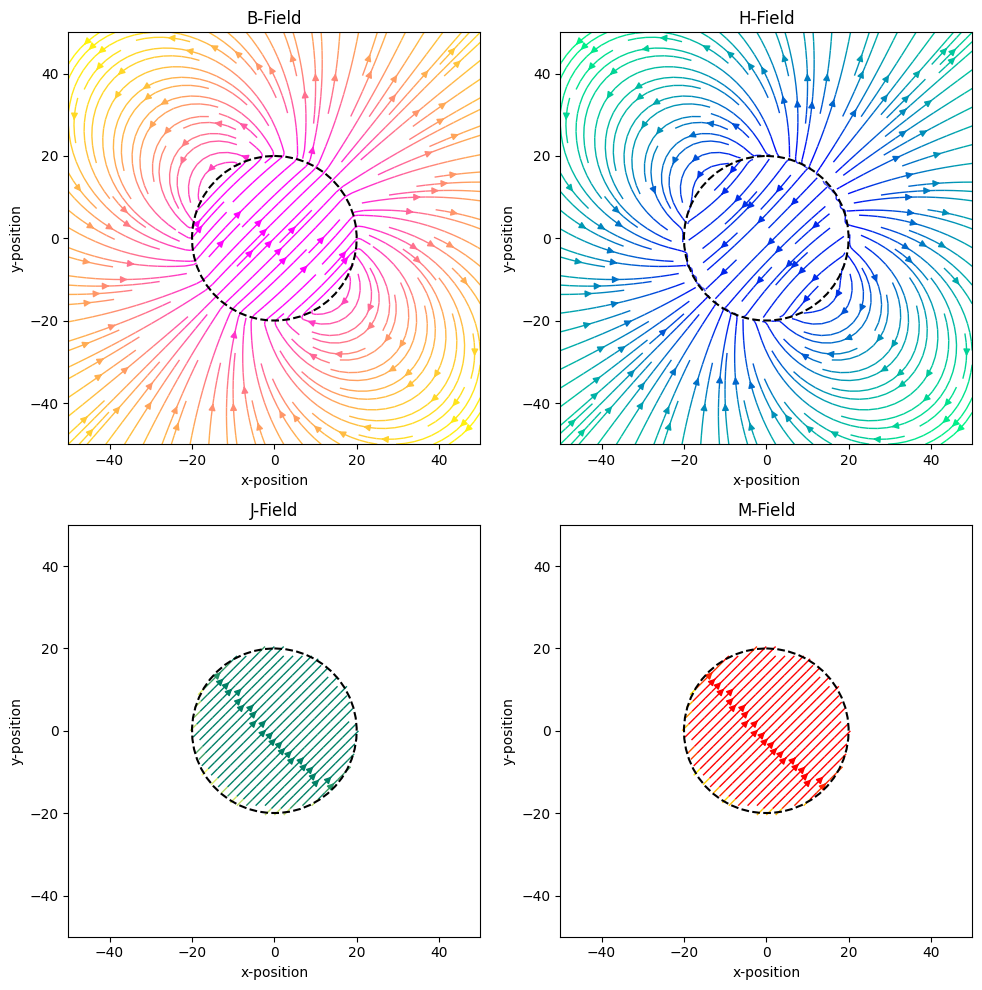

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import magpylib as magpy

fig, [[ax1,ax2], [ax3,ax4]] = plt.subplots(2, 2, figsize=(10, 10))

# Create an observer grid in the xz-symmetry plane
X, Y = np.mgrid[-50:50:100j, -50:50:100j].transpose((0, 2, 1))
grid = np.stack([X, Y, np.zeros((100, 100))], axis=2)

# Compute BHJM-fields of a cylinder magnet on the grid
cyl = magpy.magnet.Cylinder(polarization=(0.5, 0.5, 0), dimension=(40, 20))
B = cyl.getB(grid)
H = cyl.getH(grid)
J = cyl.getJ(grid)
M = cyl.getM(grid)

# Display field with Pyplot
ax1.streamplot(
    grid[:, :, 0],
    grid[:, :, 1],
    B[:, :, 0],
    B[:, :, 1],
    density=1.5,
    color=np.log(np.linalg.norm(B, axis=2)),
    linewidth=1,
    cmap="spring_r",
)
ax2.streamplot(
    grid[:, :, 0],
    grid[:, :, 1],
    H[:, :, 0],
    H[:, :, 1],
    density=1.5,
    color=np.log(np.linalg.norm(H, axis=2)),
    linewidth=1,
    cmap="winter_r",
)
ax3.streamplot(
    grid[:, :, 0],
    grid[:, :, 1],
    J[:, :, 0],
    J[:, :, 1],
    density=1.5,
    color=np.linalg.norm(J, axis=2),
    linewidth=1,
    cmap="summer_r",
)
ax4.streamplot(
    grid[:, :, 0],
    grid[:, :, 1],
    M[:, :, 0],
    M[:, :, 1],
    density=1.5,
    color=np.linalg.norm(M, axis=2),
    linewidth=1,
    cmap="autumn_r",
)

ax1.set_title("B-Field")
ax2.set_title("H-Field")
ax3.set_title("J-Field")
ax4.set_title("M-Field")

for ax in [ax1,ax2,ax3,ax4]:
    ax.set(
        xlabel="x-position",
        ylabel="y-position",
        aspect=1,
        xlim=(-50,50),
        ylim=(-50,50),
    )
    # Outline magnet boundary
    ts = np.linspace(0, 2 * np.pi, 50)
    ax.plot(20 * np.sin(ts), 20 * np.cos(ts), "k--")

plt.tight_layout()
plt.show()

(gallery-tutorial-field-computation-sensors)=

## Using Sensors

The `Sensor` class enables relative positioning of observer grids in the global coordinate system. The observer grid is stored in the `pixel` parameter of the sensor object which is `(0,0,0)` by default (sensor position = observer position).

The following example shows a moving and rotating sensor with two pixels. At the same time, the source objects are moving to demonstrate the versatility of the field computation.

In [3]:
import numpy as np

import magpylib as magpy

# Reset defaults set in previous example
magpy.defaults.reset()


# Define sensor with path
sensor = magpy.Sensor(pixel=[(0, 0, -0.0005), (0, 0, 0.0005)], style_size=1.5)
sensor.position = np.linspace((0, 0, -0.003), (0, 0, 0.003), 37)

angles = np.linspace(0, 360, 37)
sensor.rotate_from_angax(angles, "z", start=0)

# Define source with path
cyl1 = magpy.magnet.Cylinder(
    polarization=(0.1, 0, 0), dimension=(0.001, 0.002), position=(0.003, 0, 0)
)
cyl2 = cyl1.copy(position=(-0.003, 0, 0))
coll = magpy.Collection(cyl1, cyl2)
coll.rotate_from_angax(-angles, "z", start=0)

# Display system and field at sensor
with magpy.show_context(sensor, coll, animation=True, backend="plotly"):
    magpy.show(col=1)
    magpy.show(output="Bx", col=2, pixel_agg=None)

## Multiple Inputs

When `getBHJM` receive multiple inputs for sources and observers they will compute all possible combinations. It is still beneficial to call the field computation only a single time, because similar sources will be grouped and the computation will be vectorized automatically.

In [4]:
import magpylib as magpy

# Three sources
cube1 = magpy.magnet.Cuboid(polarization=(0, 0, 1), dimension=(0.1, 0.1, 0.1))
cube2 = cube1.copy()
cube3 = cube1.copy()

# Two sensors with 4x5 pixel each
pixel = [[[(i / 1000, j / 1000, 0)] for i in range(4)] for j in range(5)]
sens1 = magpy.Sensor(pixel=pixel)
sens2 = sens1.copy()

# Compute field
B = magpy.getB([cube1, cube2, cube3], [sens1, sens2])

# The result includes all combinations
B.shape

(3, 2, 5, 4, 3)

Select the second cube (first index), the first sensor (second index), pixel 3-4 (index three and four) and the Bz-component of the field (index five)

In [5]:
B[1, 0, 2, 3, 2]

0.6673035291636932

A path will add another index. Every higher pixel dimension will add another index as well.

## Field as Pandas Dataframe

Instead of a Numpy `ndarray`, the field computation can also return a [pandas](https://pandas.pydata.org/).[dataframe](https://pandas.pydata.org/docs/user_guide/dsintro.html#dataframe) using the `output='dataframe'` kwarg.

In [6]:
import numpy as np

import magpylib as magpy

cube = magpy.magnet.Cuboid(
    polarization=(0, 0, 1), dimension=(0.01, 0.01, 0.01), style_label="cube"
)
loop = magpy.current.Circle(
    current=200,
    diameter=0.02,
    style_label="loop",
)
sens1 = magpy.Sensor(
    pixel=[(0, 0, 0), (0.005, 0, 0)],
    position=np.linspace((-0.04, 0, 0.02), (0.04, 0, 0.02), 30),
    style_label="sens1",
)
sens2 = sens1.copy(style_label="sens2").move((0, 0, 0.01))

B = magpy.getB(
    [cube, loop],
    [sens1, sens2],
    output="dataframe",
)

B

source  path sensor  pixel        Bx   By        Bz
0     cube     0  sens1      0 -0.001067  0.0 -0.000356
1     cube     0  sens1      1 -0.001570  0.0 -0.000319
2     cube     0  sens2      0 -0.000917  0.0  0.000051
3     cube     0  sens2      1 -0.001204  0.0  0.000220
4     cube     1  sens1      0 -0.001317  0.0 -0.000347
..     ...   ...    ...    ...       ...  ...       ...
235   loop    28  sens2      1  0.000065  0.0  0.000002
236   loop    29  sens1      0  0.000089  0.0 -0.000026
237   loop    29  sens1      1  0.000061  0.0 -0.000026
238   loop    29  sens2      0  0.000073  0.0  0.000007
239   loop    29  sens2      1  0.000056  0.0 -0.000002

[240 rows x 7 columns]

Plotting libraries such as [plotly](https://plotly.com/python/plotly-express/) or [seaborn](https://seaborn.pydata.org/introduction.html) can take advantage of this feature, as they can deal with `dataframes` directly.

In [7]:
import plotly.express as px

fig = px.line(
    B,
    x="path",
    y="Bx",
    color="pixel",
    line_group="source",
    facet_col="source",
    symbol="sensor",
)
fig.show()

(gallery-tutorial-field-computation-functional-interface)=

## Functional Interface

All above computations demonstrate the convenient object oriented interface of Magpylib. However, there are instances when it is better to work with the functional interface instead.

1. Reduce overhead of Python objects
2. Complex computation instances

In the following example we show how complex instances are computed using the functional interface.

```{important}
The functional interface will only outperform the object oriented interface if you use numpy operations for input array creation, such as `tile`, `repeat`, `reshape`, ... !
```

In [8]:
import numpy as np

import magpylib as magpy

# Two different magnet dimensions
dim1 = (0.02, 0.04, 0.04)
dim2 = (0.04, 0.02, 0.02)
DIM = np.vstack(
    (
        np.tile(dim1, (6, 1)),
        np.tile(dim2, (6, 1)),
    )
)

# Sweep through different polarizations for each magnet type
pol = np.linspace((0, 0, 0.5), (0, 0, 1), 6)
POL = np.tile(pol, (2, 1))

# Airgap must stay the same
pos1 = (0, 0, 0.03)
pos2 = (0, 0, 0.02)
POS = np.vstack(
    (
        np.tile(pos1, (6, 1)),
        np.tile(pos2, (6, 1)),
    )
)

# Compute all instances with the functional interface
B = magpy.getB(
    sources="Cuboid",
    observers=POS,
    polarization=POL,
    dimension=DIM,
)

B.round(decimals=2)

array([[0.  , 0.  , 0.1 ],
       [0.  , 0.  , 0.12],
       [0.  , 0.  , 0.14],
       [0.  , 0.  , 0.16],
       [0.  , 0.  , 0.18],
       [0.  , 0.  , 0.19],
       [0.  , 0.  , 0.08],
       [0.  , 0.  , 0.1 ],
       [0.  , 0.  , 0.11],
       [0.  , 0.  , 0.13],
       [0.  , 0.  , 0.15],
       [0.  , 0.  , 0.16]])